In [44]:
import pandas as pd
import numpy as np
import glob
from IPython.display import clear_output

batch_size = 80
max_iter = 50
active_col = 'PstP True Active'
pains_col = 'Passes PAINS Filter'
cluster_col = 'BT_0.4 ID'
pstp_iter_file = '../../ALDD-PstP-Results/results/setting_true/training_data/cumulative_50.csv.gz'

pstp_true_file = '../datasets/pstp_final_true_with_pains.csv.gz'
true_df = pd.read_csv(pstp_true_file)

res_list = []
for i in range(max_iter):
    tmp_df = pd.read_csv('../../ALDD-PstP-Results/results/setting_true/next_batch/iter_{}.csv.gz'.format(i))
    tmp_df['iter_num'] = i
    res_list.append(tmp_df)
    
tmp_df = pd.concat(res_list)[['Index ID', 'iter_num']]
res_df = pd.read_csv(pstp_iter_file)
res_df = pd.merge(tmp_df, res_df, on='Index ID')
assert tmp_df['Index ID'].unique().shape[0] == batch_size*max_iter
assert res_df['Index ID'].unique().shape[0] == batch_size*max_iter

# add ata
ata_df = res_df[res_df['Molecule'].str.contains('ATA')].copy()
ata_df[pains_col] = 1
res_df = res_df.merge(true_df[['Molecule', pains_col]], on='Molecule')
res_df = pd.concat([ata_df, res_df])
true_df = pd.concat([ata_df[true_df.columns], true_df])

In [45]:
screened_actives_df = res_df[(res_df[active_col] == 1)]
true_actives_df = true_df[(true_df[active_col] == 1)]
total_hits, total_unique_hits = screened_actives_df.shape[0], screened_actives_df[cluster_col].unique().shape[0]
dataset_size, screened_size = true_df.shape[0], res_df.shape[0] 
true_total_hits, true_total_unique_hits = true_actives_df.shape[0], true_actives_df[cluster_col].unique().shape[0]
fraction_screened, fraction_hits_found, fraction_uhits_found = screened_size/dataset_size, total_hits/true_total_hits, total_unique_hits/true_total_unique_hits
hit_perc = true_total_hits/dataset_size
hits_expected = screened_size*(true_total_hits/dataset_size)

print('Batch size: {}. # iters: {}. Total selected cpds: {}.'.format(batch_size,  max_iter, screened_size))
print('Dataset size: {}. Total hits in dataset: {}. Total unique hits in dataset: {}'.format(dataset_size, true_total_hits, true_total_unique_hits))
print('Hit %: {:.2f}%. Hits expected in {} cpds: {:.2f} hits.'.format(100.0*hit_perc, screened_size, hits_expected))
print('Total hits found: {}. Total unique hits found: {}.'.format(total_hits, total_unique_hits))
print('Percent of dataset screened: {:.2f}%. Percent of hits found: {:.2f}%. Percent of unique hits found: {:.2f}%.'.format(100*fraction_screened, 
                                                                               100*fraction_hits_found,
                                                                               100*fraction_uhits_found))

Batch size: 80. # iters: 50. Total selected cpds: 4000.
Dataset size: 94044. Total hits in dataset: 143. Total unique hits in dataset: 127
Hit %: 0.15%. Hits expected in 4000 cpds: 6.08 hits.
Total hits found: 29. Total unique hits found: 27.
Percent of dataset screened: 4.25%. Percent of hits found: 20.28%. Percent of unique hits found: 21.26%.


---
# Uniform Random Sampling of Training Set 

In [55]:
import time
import pathlib
import warnings
warnings.filterwarnings('ignore')

output_file_fmt = '../datasets/pstp/one_round_screening/random/size_{}/sample_{}/train.csv.gz'
max_size = 4000
seeds_list = [55886611, 91555713, 10912561, 69210899, 75538109, 
              33176925, 17929553, 26974345, 63185387, 54808003]
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

start_time = time.time()

for sample_size in sample_size_list:
    for seed_idx, seed in enumerate(seeds_list):
        train_file = output_file_fmt.format(sample_size, seed_idx)
        pathlib.Path(train_file).parent.mkdir(parents=True, exist_ok=True)
        
        np.random.seed(seed)
        cpds_to_select = np.random.choice(dataset_size, replace=False, size=sample_size)
        cpds_to_select[0] = 0 # add ATA instead of first sample cpd
        
        sample_df = true_df.iloc[cpds_to_select,:]
        sample_df.to_csv(train_file, compression='gzip', index=False)
        
        assert sample_df['Molecule'].isin(['CID2259_ATA']).sum() == 1
        
        print('Sampled {} compounds with seed {}.'.format(sample_df.shape[0], seed))
    
    print('---------------------------------------------------------------------------')
    
print('Total time {} minutes.'.format((time.time() - start_time)/60.0))

Sampled 400 compounds with seed 55886611.
Sampled 400 compounds with seed 91555713.
Sampled 400 compounds with seed 10912561.
Sampled 400 compounds with seed 69210899.
Sampled 400 compounds with seed 75538109.
Sampled 400 compounds with seed 33176925.
Sampled 400 compounds with seed 17929553.
Sampled 400 compounds with seed 26974345.
Sampled 400 compounds with seed 63185387.
Sampled 400 compounds with seed 54808003.
---------------------------------------------------------------------------
Sampled 800 compounds with seed 55886611.
Sampled 800 compounds with seed 91555713.
Sampled 800 compounds with seed 10912561.
Sampled 800 compounds with seed 69210899.
Sampled 800 compounds with seed 75538109.
Sampled 800 compounds with seed 33176925.
Sampled 800 compounds with seed 17929553.
Sampled 800 compounds with seed 26974345.
Sampled 800 compounds with seed 63185387.
Sampled 800 compounds with seed 54808003.
---------------------------------------------------------------------------
Sampled 

---
# Diversity (Tanimito Dissimilarity) Sampling of Training Set 

In [102]:
import time
import pathlib
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
import warnings
warnings.filterwarnings('ignore')

output_file_fmt = '../datasets/pstp/one_round_screening/diversity/size_{}/sample_0/train.csv.gz'
max_size = 4000
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

for sample_size in sample_size_list:
    start_time = time.time()
    cpds_to_select = [0] # select first compound as ATA 
    train_file = output_file_fmt.format(sample_size)
    pathlib.Path(train_file).parent.mkdir(parents=True, exist_ok=True)
    
    X_prosp = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in true_df['Morgan FP_2_1024']]).astype(float)
    for i in range(1, sample_size):
        x = X_prosp[cpds_to_select,:]
        remaining_cpds = np.setdiff1d(np.arange(X_prosp.shape[0]), cpds_to_select)
        y = X_prosp[remaining_cpds,:]
        
        # adapted from: https://github.com/deepchem/deepchem/blob/2531eca8564c1dc68910d791b0bcd91fd586afb9/deepchem/trans/transformers.py#L752
        numerator = np.dot(y, x.T).flatten() # equivalent to np.bitwise_and(X_batch, Y_batch), axis=1)
        denominator = 1024 - np.dot(1-y, (1-x).T).flatten() # np.sum(np.bitwise_or(X_rep, Y_rep), axis=1)

        tandist = numerator / denominator
        tandist = 1.0 - tandist

        tandist = tandist.reshape(y.shape[0], -1)
        
        mean_dist_to_selected = tandist.mean(axis=1)
        farthest_idx = np.argmax(mean_dist_to_selected)

        cpds_to_select.append(remaining_cpds[farthest_idx])

    sample_df = true_df.iloc[cpds_to_select,:]
    sample_df.to_csv(train_file, compression='gzip', index=False)
    
    assert sample_df['Molecule'].isin(['CID2259_ATA']).sum() == 1
    
    print('Diversity sampled {} compounds. Time {} minutes.'.format(sample_size, (time.time() - start_time)/60.0))

Diversity sampled 400 compounds. Time 8.631892410914103 minutes.
Diversity sampled 800 compounds. Time 26.711431741714478 minutes.
Diversity sampled 1200 compounds. Time 52.85286370118459 minutes.
Diversity sampled 1600 compounds. Time 85.9373074054718 minutes.
Diversity sampled 2000 compounds. Time 127.61310313542684 minutes.
Diversity sampled 2400 compounds. Time 177.2579901178678 minutes.
Diversity sampled 2800 compounds. Time 234.9540247162183 minutes.
Diversity sampled 3200 compounds. Time 300.3853029648463 minutes.
Diversity sampled 3600 compounds. Time 374.5990753809611 minutes.


---
#### HTCondor DAG for PstP ors

In [ ]:
# Setting up HTCondor Dag

line1 = 'JOB PSTP_ORS_{} pstp.sub'
line2 = 'VARS PSTP_ORS_{} args="{} {}" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code6.tar.gz" transfer_output_files="./results_{}.tar.gz" hpname="PSTP_ORS_{}" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pstp.log"'
line3 = 'SCRIPT POST PSTP_ORS_{} ./post_job_script.sh ./results_{}.tar.gz'

output_file_fmt = '../datasets/pstp/one_round_screening/random/size_{}/sample_{}/'
max_size = 4000
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

job_num = 0
# random sampling
for sample_size in sample_size_list:
    for seed_idx in range(10):
        train_dir = output_file_fmt.format(sample_size, seed_idx)
        
        print(line1.format(job_num))
        print(line2.format(job_num, train_dir, job_num, job_num, job_num))
        print(line3.format(job_num, job_num))
        
        job_num = job_num + 1

# diversity sampling
output_file_fmt = '../datasets/pstp/one_round_screening/diversity/size_{}/sample_0/'
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

for sample_size in sample_size_list:
    train_dir = output_file_fmt.format(sample_size)
    
    print(line1.format(job_num))
    print(line2.format(job_num, train_dir, job_num, job_num, job_num))
    print(line3.format(job_num, job_num))

    job_num = job_num + 1

---
# Process Results

In [74]:
import pandas as pd
import numpy as np
import glob
from IPython.display import clear_output

info_cols = ['Index ID', 'Molecule', 'PubChem_CID', 'SMILES', 'BT_0.4 ID']

max_size = 4000
res_list = []

output_file_fmt = '../datasets/pstp/one_round_screening/results/one_round_screening/{}/size_{}/sample_{}/'
sampling_type_list = ['random', 'diversity']
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

for sampling_type in sampling_type_list:
    for sample_size in sample_size_list:
        num_samples = 1
        if sampling_type == 'random':
            num_samples = 10
        for seed_idx in range(num_samples):
            results_dir = output_file_fmt.format(sampling_type, sample_size, seed_idx)
            train_file = results_dir + '/train.csv.gz'
            selected_file = results_dir + '/selected.csv.gz'

            train_df = pd.read_csv(train_file)
            selected_df = pd.read_csv(selected_file)
            selected_df = selected_df[info_cols]
            selected_df = selected_df.merge(true_df[['Molecule', 'PstP True Active', 'Passes PAINS Filter']], on='Molecule')
            
            train_hits = train_df[train_df['PstP True Active'] == 1]
            train_hits = train_hits[train_hits['Passes PAINS Filter'] == 1]
            selected_hits = selected_df[selected_df['PstP True Active'] == 1]
            selected_hits = selected_hits[selected_hits['Passes PAINS Filter'] == 1]

            total_hits = train_hits.shape[0] + selected_hits.shape[0]
            total_unique_hits = train_hits['BT_0.4 ID'].unique().shape[0] + selected_hits['BT_0.4 ID'].unique().shape[0]

            curr_results = [sampling_type, sample_size, seed_idx, 
                            train_hits.shape[0], selected_hits.shape[0], total_hits, total_unique_hits]
            res_list.append(curr_results)
            
res_df = pd.DataFrame(data=res_list, 
                      columns=['Sampling Type', 'Sample Size', 'Sample Replicate', 
                               'Train Hits', 'Selected Hits', 'Total Hits', 'Total Unique Hits'])

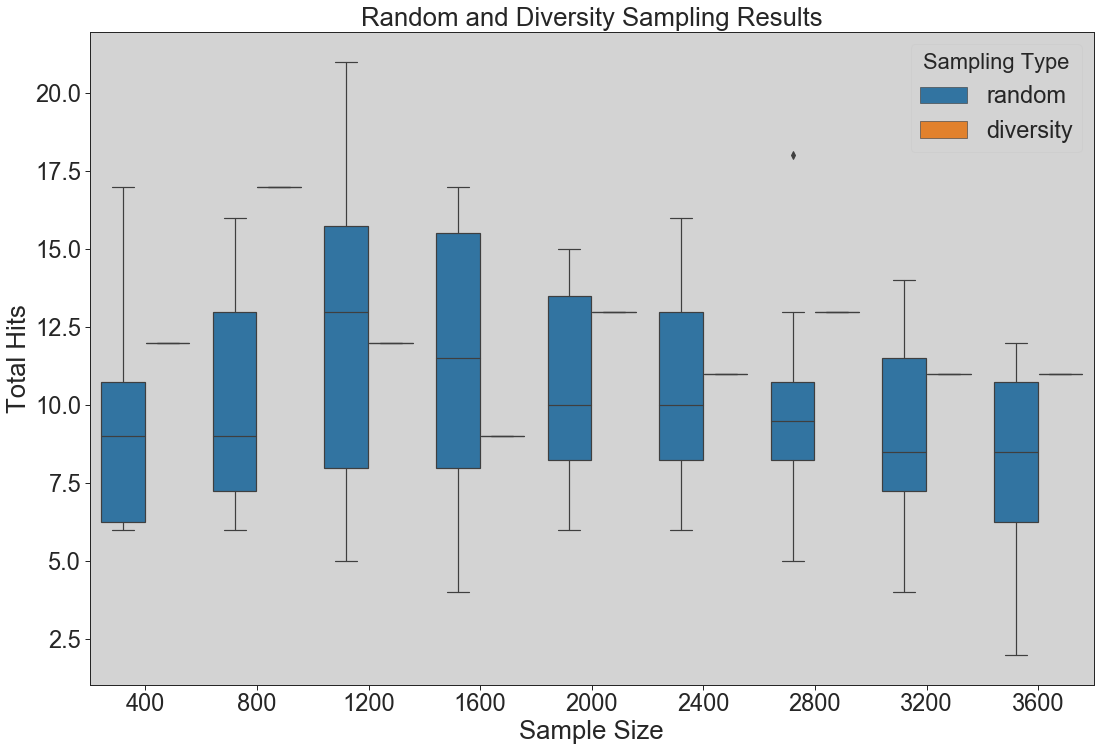

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks", rc={'axes.facecolor':'lightgrey'})
sns.set_context("paper", font_scale=2.68)
figsize=(18, 12)

plt.figure(figsize=figsize)

sns.boxplot(x='Sample Size', y='Total Hits', hue='Sampling Type', data=res_df)
plt.title('Random and Diversity Sampling Results');

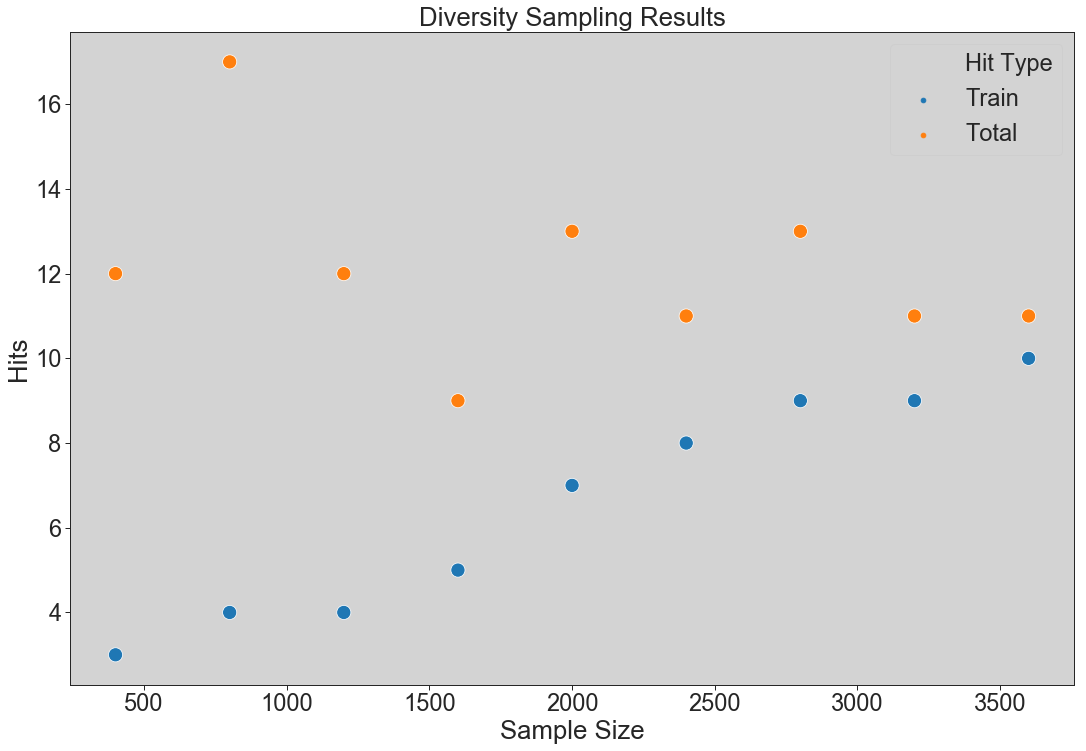

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks", rc={'axes.facecolor':'lightgrey'})
sns.set_context("paper", font_scale=2.68)
figsize=(18, 12)

plt.figure(figsize=figsize)

diversity_df1 = res_df[res_df['Sampling Type'] == 'diversity']
diversity_df1['Hit Type'] = 'Total'
diversity_df2 = diversity_df1.copy()
diversity_df1['Hit Type'] = 'Train'

diversity_df1['Hits'] = diversity_df1['Train Hits']
diversity_df2['Hits'] = diversity_df1['Total Hits']

data_df = pd.concat([diversity_df1, diversity_df2])

sns.scatterplot(x='Sample Size', y='Hits', hue='Hit Type', data=data_df, s=200)
plt.title('Diversity Sampling Results');

In [77]:
diversity_df1

Sampling Type  Sample Size  Sample Replicate  Train Hits  Selected Hits  \
90     diversity          400                 0           3              9   
91     diversity          800                 0           4             13   
92     diversity         1200                 0           4              8   
93     diversity         1600                 0           5              4   
94     diversity         2000                 0           7              6   
95     diversity         2400                 0           8              3   
96     diversity         2800                 0           9              4   
97     diversity         3200                 0           9              2   
98     diversity         3600                 0          10              1   

    Total Hits  Total Unique Hits Hit Type  Hits  
90          12                 12    Train     3  
91          17                 17    Train     4  
92          12                 12    Train     4  
93           9                  9    Train     5  
94          13                 12    Train     7  
95          11                 11    Train     8  
96          13                 13    Train     9  
97          11                 11    Train     9  
98          11                 11    Train    10

In [78]:
df1 = res_df[res_df['Sampling Type'] == 'random']

In [79]:
df1

Sampling Type  Sample Size  Sample Replicate  Train Hits  Selected Hits  \
0         random          400                 0           1              6   
1         random          400                 1           2              8   
2         random          400                 2           1              5   
3         random          400                 3           2              9   
4         random          400                 4           1              9   
5         random          400                 5           1              5   
6         random          400                 6           1              5   
7         random          400                 7           2             12   
8         random          400                 8           1             16   
9         random          400                 9           1              7   
10        random          800                 0           1              6   
11        random          800                 1           2              5   
12        random          800                 2           3             12   
13        random          800                 3           2              7   
14        random          800                 4           1              7   
15        random          800                 5           2             12   
16        random          800                 6           1              9   
17        random          800                 7           3              6   
18        random          800                 8           1             15   
19        random          800                 9           1              5   
20        random         1200                 0           5             16   
21        random         1200                 1           2              6   
22        random         1200                 2           3             13   
23        random         1200                 3           2             11   
24        random         1200                 4           2              4   
25        random         1200                 5           3             13   
26        random         1200                 6           1              4   
27        random         1200                 7           4             11   
28        random         1200                 8           2             11   
29        random         1200                 9           1              7   
..           ...          ...               ...         ...            ...   
60        random         2800                 0           8             10   
61        random         2800                 1           3              5   
62        random         2800                 2           4              5   
63        random         2800                 3           4              6   
64        random         2800                 4           5              8   
65        random         2800                 5           4              6   
66        random         2800                 6           2              4   
67        random         2800                 7           5              4   
68        random         2800                 8           3              8   
69        random         2800                 9           3              2   
70        random         3200                 0           8              4   
71        random         3200                 1           3              4   
72        random         3200                 2           4              4   
73        random         3200                 3           5              2   
74        random         3200                 4           5              9   
75        random         3200                 5           5              3   
76        random         3200                 6           2              2   
77        random         3200                 7           5              4   
78        random         3200                 8           4             10   
79        random         

---
# PCBA - One Round Screening - Prepare HTC DAG

In [80]:
import numpy as np
import pandas as pd
import os
import glob
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

recompute_task_info=False
if recompute_task_info:
    task_names = [r.split('\\')[-2][:-6] for r in glob.glob('../datasets/pcba/*_cv_96/')]
    task_hit_dict = {}
    for task_col in task_names:
        task_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/unlabeled_*.csv'.format(task_col))])
        cpd_count = task_df.shape[0]
        hit_limit = task_df[task_col].sum()
        unique_hit_limit = task_df[task_df[task_col] == 1][cluster_col].unique().shape[0]
        task_hit_dict[task_col] = (hit_limit, unique_hit_limit, cpd_count)
else:
    import pickle
    with open('task_info_dict.pickle', 'rb') as handle:
        task_hit_dict = pickle.load(handle)

In [113]:
data = []
for task in task_hit_dict:
    hit, uhit, cpd_count = task_hit_dict[task]
    data.append([task, hit, uhit, cpd_count])

summary_df = pd.DataFrame(data=data, columns=['task', 'hit_limit', 'unique_hit_limit', 'cpd_count'])

summary_df['active_ratio'] = np.around(100.0 * summary_df['hit_limit'] / summary_df['cpd_count'], decimals=2)

In [114]:
# these are 108 of the 128 PCBA targets.
# There are 108 targets that have over 100,000 compounds
tasks = ['pcba-aid881', 'pcba-aid1454',
         'pcba-aid902', 'pcba-aid924', 'pcba-aid1452', 'pcba-aid1030', 'pcba-aid2242', 'pcba-aid2147',
         'pcba-aid1458', 'pcba-aid1379', 'pcba-aid540276', 'pcba-aid1457', 'pcba-aid1688',
         'pcba-aid1461', 'pcba-aid485360', 'pcba-aid1471', 'pcba-aid1460', 'pcba-aid2549',
         'pcba-aid504467', 'pcba-aid2675', 'pcba-aid1468', 'pcba-aid1631', 'pcba-aid2326',
         'pcba-aid1634', 'pcba-aid1479', 'pcba-aid2551', 'pcba-aid1469', 'pcba-aid2451',
         'pcba-aid2546', 'pcba-aid720579', 'pcba-aid2662', 'pcba-aid504444', 'pcba-aid1721',
         'pcba-aid624296', 'pcba-aid2100', 'pcba-aid504332', 'pcba-aid686978', 'pcba-aid624287',
         'pcba-aid504706', 'pcba-aid686979', 'pcba-aid720580', 'pcba-aid624297', 'pcba-aid485294',
         'pcba-aid2101', 'pcba-aid485297', 'pcba-aid504466', 'pcba-aid485313', 'pcba-aid485281',
         'pcba-aid485314', 'pcba-aid485349', 'pcba-aid652105', 'pcba-aid485353', 'pcba-aid651965',
         'pcba-aid624288', 'pcba-aid504842', 'pcba-aid624417', 'pcba-aid504333', 'pcba-aid485367',
         'pcba-aid588342', 'pcba-aid485341', 'pcba-aid463254', 'pcba-aid492947', 'pcba-aid624291',
         'pcba-aid2517', 'pcba-aid485290', 'pcba-aid686970', 'pcba-aid720553', 'pcba-aid2528',
         'pcba-aid485364', 'pcba-aid720551', 'pcba-aid651635', 'pcba-aid720504', 'pcba-aid588855',
         'pcba-aid720709', 'pcba-aid651644', 'pcba-aid504339', 'pcba-aid588590', 'pcba-aid720542',
         'pcba-aid720708', 'pcba-aid651768', 'pcba-aid2676', 'pcba-aid504891', 'pcba-aid652106',
         'pcba-aid720707', 'pcba-aid720711', 'pcba-aid652025', 'pcba-aid624246', 'pcba-aid624202',
         'pcba-aid743255', 'pcba-aid588453', 'pcba-aid540317', 'pcba-aid504327',
         'pcba-aid504845', 'pcba-aid588591', 'pcba-aid602313', 'pcba-aid652104', 'pcba-aid588795',
         'pcba-aid602233', 'pcba-aid504847', 'pcba-aid588456', 'pcba-aid602179', 'pcba-aid588579',
         'pcba-aid602310', 'pcba-aid624171', 'pcba-aid624170', 'pcba-aid743266', 'pcba-aid602332', 
         'pcba-aid624173']

# we exclude 'pcba-aid624173' because it was used in experiment 1
# the other 5 were excluded from experiment 3 due to high active_ratios in the range [6%, 20%]
# so in experiment 4 we have 102 PCBA tasks (same as in experiment 3)
excluded_tasks = ['pcba-aid588342','pcba-aid1030', 'pcba-aid504332', 'pcba-aid686979', 'pcba-aid686978', 
                  'pcba-aid624173']

summary_df = summary_df[summary_df['task'].isin(tasks)]
summary_df = summary_df[~summary_df['task'].isin(excluded_tasks)]

---
#### HTCondor DAG for PCBA ors

In [120]:
# Setting up HTCondor Dag
line1 = 'JOB PCBA_ORS_{} pcba_ors.sub'
line2 = 'VARS PCBA_ORS_{} args="{} {}" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_{}.tar.gz" hpname="PSTP_ORS_{}" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"'
line3 = 'SCRIPT POST PCBA_ORS_{} ./post_job_script.sh ./results_{}.tar.gz'

output_file_fmt = '../datasets/pcba/{}/one_round_screening/random/size_{}/sample_{}/'
max_size = 96*50 # or 80*50
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

job_num = 0
# random sampling
for pcba_task in tasks:
    for sample_size in sample_size_list:
        for seed_idx in range(10):
            train_dir = output_file_fmt.format(pcba_task, sample_size, seed_idx)

            print(line1.format(job_num))
            print(line2.format(job_num, train_dir, job_num, job_num, job_num))
            print(line3.format(job_num, job_num))

            job_num = job_num + 1

# diversity sampling
output_file_fmt = '../datasets/pcba/{}/one_round_screening/diversity/size_{}/sample_0/'
sample_size_list = (max_size*np.linspace(0.1, 0.9, 9)).astype(int)

for pcba_task in tasks:
    for sample_size in sample_size_list:
        train_dir = output_file_fmt.format(pcba_task, sample_size)

        print(line1.format(job_num))
        print(line2.format(job_num, train_dir, job_num, job_num, job_num))
        print(line3.format(job_num, job_num))

        job_num = job_num + 1

JOB PCBA_ORS_0 pcba_ors.sub
VARS PCBA_ORS_0 args="../datasets/pcba/pcba-aid881/one_round_screening/random/size_480/sample_0/ 0" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_0.tar.gz" hpname="PSTP_ORS_0" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_0 ./post_job_script.sh ./results_0.tar.gz
JOB PCBA_ORS_1 pcba_ors.sub
VARS PCBA_ORS_1 args="../datasets/pcba/pcba-aid881/one_round_screening/random/size_480/sample_1/ 1" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_1.tar.gz" hpname="PSTP_ORS_1" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfil

JOB PCBA_ORS_345 pcba_ors.sub
VARS PCBA_ORS_345 args="../datasets/pcba/pcba-aid924/one_round_screening/random/size_3840/sample_5/ 345" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_345.tar.gz" hpname="PSTP_ORS_345" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_345 ./post_job_script.sh ./results_345.tar.gz
JOB PCBA_ORS_346 pcba_ors.sub
VARS PCBA_ORS_346 args="../datasets/pcba/pcba-aid924/one_round_screening/random/size_3840/sample_6/ 346" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_346.tar.gz" hpname="PSTP_ORS_346" qcount="1" reqs="(true)" ramreq

SCRIPT POST PCBA_ORS_757 ./post_job_script.sh ./results_757.tar.gz
JOB PCBA_ORS_758 pcba_ors.sub
VARS PCBA_ORS_758 args="../datasets/pcba/pcba-aid1458/one_round_screening/random/size_1920/sample_8/ 758" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_758.tar.gz" hpname="PSTP_ORS_758" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_758 ./post_job_script.sh ./results_758.tar.gz
JOB PCBA_ORS_759 pcba_ors.sub
VARS PCBA_ORS_759 args="../datasets/pcba/pcba-aid1458/one_round_screening/random/size_1920/sample_9/ 759" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./resu

SCRIPT POST PCBA_ORS_1150 ./post_job_script.sh ./results_1150.tar.gz
JOB PCBA_ORS_1151 pcba_ors.sub
VARS PCBA_ORS_1151 args="../datasets/pcba/pcba-aid1688/one_round_screening/random/size_3840/sample_1/ 1151" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_1151.tar.gz" hpname="PSTP_ORS_1151" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_1151 ./post_job_script.sh ./results_1151.tar.gz
JOB PCBA_ORS_1152 pcba_ors.sub
VARS PCBA_ORS_1152 args="../datasets/pcba/pcba-aid1688/one_round_screening/random/size_3840/sample_2/ 1152" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_f

VARS PCBA_ORS_1533 args="../datasets/pcba/pcba-aid2549/one_round_screening/random/size_480/sample_3/ 1533" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_1533.tar.gz" hpname="PSTP_ORS_1533" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_1533 ./post_job_script.sh ./results_1533.tar.gz
JOB PCBA_ORS_1534 pcba_ors.sub
VARS PCBA_ORS_1534 args="../datasets/pcba/pcba-aid2549/one_round_screening/random/size_480/sample_4/ 1534" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_1534.tar.gz" hpname="PSTP_ORS_1534" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40"

VARS PCBA_ORS_1909 args="../datasets/pcba/pcba-aid1631/one_round_screening/random/size_960/sample_9/ 1909" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_1909.tar.gz" hpname="PSTP_ORS_1909" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_1909 ./post_job_script.sh ./results_1909.tar.gz
JOB PCBA_ORS_1910 pcba_ors.sub
VARS PCBA_ORS_1910 args="../datasets/pcba/pcba-aid1631/one_round_screening/random/size_1440/sample_0/ 1910" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_1910.tar.gz" hpname="PSTP_ORS_1910" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40

VARS PCBA_ORS_2334 args="../datasets/pcba/pcba-aid2551/one_round_screening/random/size_4320/sample_4/ 2334" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_2334.tar.gz" hpname="PSTP_ORS_2334" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_2334 ./post_job_script.sh ./results_2334.tar.gz
JOB PCBA_ORS_2335 pcba_ors.sub
VARS PCBA_ORS_2335 args="../datasets/pcba/pcba-aid2551/one_round_screening/random/size_4320/sample_5/ 2335" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_2335.tar.gz" hpname="PSTP_ORS_2335" qcount="1" reqs="(true)" ramreqs="8" diskreqs="4

SCRIPT POST PCBA_ORS_2777 ./post_job_script.sh ./results_2777.tar.gz
JOB PCBA_ORS_2778 pcba_ors.sub
VARS PCBA_ORS_2778 args="../datasets/pcba/pcba-aid2662/one_round_screening/random/size_3840/sample_8/ 2778" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_2778.tar.gz" hpname="PSTP_ORS_2778" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_2778 ./post_job_script.sh ./results_2778.tar.gz
JOB PCBA_ORS_2779 pcba_ors.sub
VARS PCBA_ORS_2779 args="../datasets/pcba/pcba-aid2662/one_round_screening/random/size_3840/sample_9/ 2779" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_f

VARS PCBA_ORS_3174 args="../datasets/pcba/pcba-aid504332/one_round_screening/random/size_1440/sample_4/ 3174" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_3174.tar.gz" hpname="PSTP_ORS_3174" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_3174 ./post_job_script.sh ./results_3174.tar.gz
JOB PCBA_ORS_3175 pcba_ors.sub
VARS PCBA_ORS_3175 args="../datasets/pcba/pcba-aid504332/one_round_screening/random/size_1440/sample_5/ 3175" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_3175.tar.gz" hpname="PSTP_ORS_3175" qcount="1" reqs="(true)" ramreqs="8" diskreq

JOB PCBA_ORS_3547 pcba_ors.sub
VARS PCBA_ORS_3547 args="../datasets/pcba/pcba-aid686979/one_round_screening/random/size_1920/sample_7/ 3547" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_3547.tar.gz" hpname="PSTP_ORS_3547" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_3547 ./post_job_script.sh ./results_3547.tar.gz
JOB PCBA_ORS_3548 pcba_ors.sub
VARS PCBA_ORS_3548 args="../datasets/pcba/pcba-aid686979/one_round_screening/random/size_1920/sample_8/ 3548" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_3548.tar.gz" hpname="PSTP_ORS_3548" qcount="1" re

JOB PCBA_ORS_3964 pcba_ors.sub
VARS PCBA_ORS_3964 args="../datasets/pcba/pcba-aid485297/one_round_screening/random/size_480/sample_4/ 3964" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_3964.tar.gz" hpname="PSTP_ORS_3964" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_3964 ./post_job_script.sh ./results_3964.tar.gz
JOB PCBA_ORS_3965 pcba_ors.sub
VARS PCBA_ORS_3965 args="../datasets/pcba/pcba-aid485297/one_round_screening/random/size_480/sample_5/ 3965" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_3965.tar.gz" hpname="PSTP_ORS_3965" qcount="1" reqs

JOB PCBA_ORS_4432 pcba_ors.sub
VARS PCBA_ORS_4432 args="../datasets/pcba/pcba-aid485349/one_round_screening/random/size_1440/sample_2/ 4432" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_4432.tar.gz" hpname="PSTP_ORS_4432" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_4432 ./post_job_script.sh ./results_4432.tar.gz
JOB PCBA_ORS_4433 pcba_ors.sub
VARS PCBA_ORS_4433 args="../datasets/pcba/pcba-aid485349/one_round_screening/random/size_1440/sample_3/ 4433" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_4433.tar.gz" hpname="PSTP_ORS_4433" qcount="1" re

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



JOB PCBA_ORS_7989 pcba_ors.sub
VARS PCBA_ORS_7989 args="../datasets/pcba/pcba-aid743255/one_round_screening/random/size_3360/sample_9/ 7989" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_7989.tar.gz" hpname="PSTP_ORS_7989" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_7989 ./post_job_script.sh ./results_7989.tar.gz
JOB PCBA_ORS_7990 pcba_ors.sub
VARS PCBA_ORS_7990 args="../datasets/pcba/pcba-aid743255/one_round_screening/random/size_3840/sample_0/ 7990" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_7990.tar.gz" hpname="PSTP_ORS_7990" qcount="1" re

JOB PCBA_ORS_8407 pcba_ors.sub
VARS PCBA_ORS_8407 args="../datasets/pcba/pcba-aid588591/one_round_screening/random/size_1920/sample_7/ 8407" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_8407.tar.gz" hpname="PSTP_ORS_8407" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_8407 ./post_job_script.sh ./results_8407.tar.gz
JOB PCBA_ORS_8408 pcba_ors.sub
VARS PCBA_ORS_8408 args="../datasets/pcba/pcba-aid588591/one_round_screening/random/size_1920/sample_8/ 8408" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_8408.tar.gz" hpname="PSTP_ORS_8408" qcount="1" re

JOB PCBA_ORS_8789 pcba_ors.sub
VARS PCBA_ORS_8789 args="../datasets/pcba/pcba-aid602233/one_round_screening/random/size_2880/sample_9/ 8789" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_8789.tar.gz" hpname="PSTP_ORS_8789" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_8789 ./post_job_script.sh ./results_8789.tar.gz
JOB PCBA_ORS_8790 pcba_ors.sub
VARS PCBA_ORS_8790 args="../datasets/pcba/pcba-aid602233/one_round_screening/random/size_3360/sample_0/ 8790" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_8790.tar.gz" hpname="PSTP_ORS_8790" qcount="1" re

SCRIPT POST PCBA_ORS_9165 ./post_job_script.sh ./results_9165.tar.gz
JOB PCBA_ORS_9166 pcba_ors.sub
VARS PCBA_ORS_9166 args="../datasets/pcba/pcba-aid588579/one_round_screening/random/size_3840/sample_6/ 9166" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_9166.tar.gz" hpname="PSTP_ORS_9166" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_9166 ./post_job_script.sh ./results_9166.tar.gz
JOB PCBA_ORS_9167 pcba_ors.sub
VARS PCBA_ORS_9167 args="../datasets/pcba/pcba-aid588579/one_round_screening/random/size_3840/sample_7/ 9167" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_outp

SCRIPT POST PCBA_ORS_9562 ./post_job_script.sh ./results_9562.tar.gz
JOB PCBA_ORS_9563 pcba_ors.sub
VARS PCBA_ORS_9563 args="../datasets/pcba/pcba-aid602332/one_round_screening/random/size_1440/sample_3/ 9563" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_9563.tar.gz" hpname="PSTP_ORS_9563" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_9563 ./post_job_script.sh ./results_9563.tar.gz
JOB PCBA_ORS_9564 pcba_ors.sub
VARS PCBA_ORS_9564 args="../datasets/pcba/pcba-aid602332/one_round_screening/random/size_1440/sample_4/ 9564" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_outp

VARS PCBA_ORS_9989 args="../datasets/pcba/pcba-aid720579/one_round_screening/diversity/size_4320/sample_0/ 9989" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_9989.tar.gz" hpname="PSTP_ORS_9989" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_9989 ./post_job_script.sh ./results_9989.tar.gz
JOB PCBA_ORS_9990 pcba_ors.sub
VARS PCBA_ORS_9990 args="../datasets/pcba/pcba-aid2662/one_round_screening/diversity/size_480/sample_0/ 9990" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_9990.tar.gz" hpname="PSTP_ORS_9990" qcount="1" reqs="(true)" ramreqs="8" disk

SCRIPT POST PCBA_ORS_10403 ./post_job_script.sh ./results_10403.tar.gz
JOB PCBA_ORS_10404 pcba_ors.sub
VARS PCBA_ORS_10404 args="../datasets/pcba/pcba-aid588590/one_round_screening/diversity/size_480/sample_0/ 10404" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.gz" transfer_output_files="./results_10404.tar.gz" hpname="PSTP_ORS_10404" qcount="1" reqs="(true)" ramreqs="8" diskreqs="40" logfilename="exp_pcba_ors.log"
SCRIPT POST PCBA_ORS_10404 ./post_job_script.sh ./results_10404.tar.gz
JOB PCBA_ORS_10405 pcba_ors.sub
VARS PCBA_ORS_10405 args="../datasets/pcba/pcba-aid588590/one_round_screening/diversity/size_960/sample_0/ 10405" transfer_input_files="http://proxy.chtc.wisc.edu/SQUID/alnammi/anaconda.sh, http://proxy.chtc.wisc.edu/SQUID/alnammi/bzip2c.tar.gz, http://proxy.chtc.wisc.edu/SQUID/alnammi/active_learning_pstp/code8.tar.g

In [131]:
108*(9 + 9*10)

10692

In [132]:
job_num

10692

In [129]:
len(sample_size_list)

9